Chapter 1 - Multinomial BNs - Paramaterize BNs from Data

Train Survey

- Age - young, adult, old
- Sex - male, female
- Education - high (high-school), university degree
- Occupation - emp (employee), self-employed (self)
- Residence - city size: small, big
- Transportation - car, train, other

This time we're going to parameters the BN but we don't know what the paramters are. Although we do have data (and the relations structure). So, we're going to parameterize based on data.

In [3]:
install.packages(
  "bnlearn",
  repos = "https://cloud.r-project.org",   # CRAN mirror
  dependencies = TRUE                      # pulls in igraph, gRain, etc.
)
library(bnlearn)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“dependencies ‘graph’, ‘Rgraphviz’ are not available”
also installing the dependencies ‘RcppEigen’, ‘RcppArmadillo’, ‘igraph’, ‘gRbase’, ‘gRain’, ‘Rmpfr’, ‘gmp’


Warning message in install.packages("bnlearn", repos = "https://cloud.r-project.org", :
“installation of package ‘gmp’ had non-zero exit status”
Warning message in install.packages("bnlearn", repos = "https://cloud.r-project.org", :
“installation of package ‘Rmpfr’ had non-zero exit status”


### create DAG

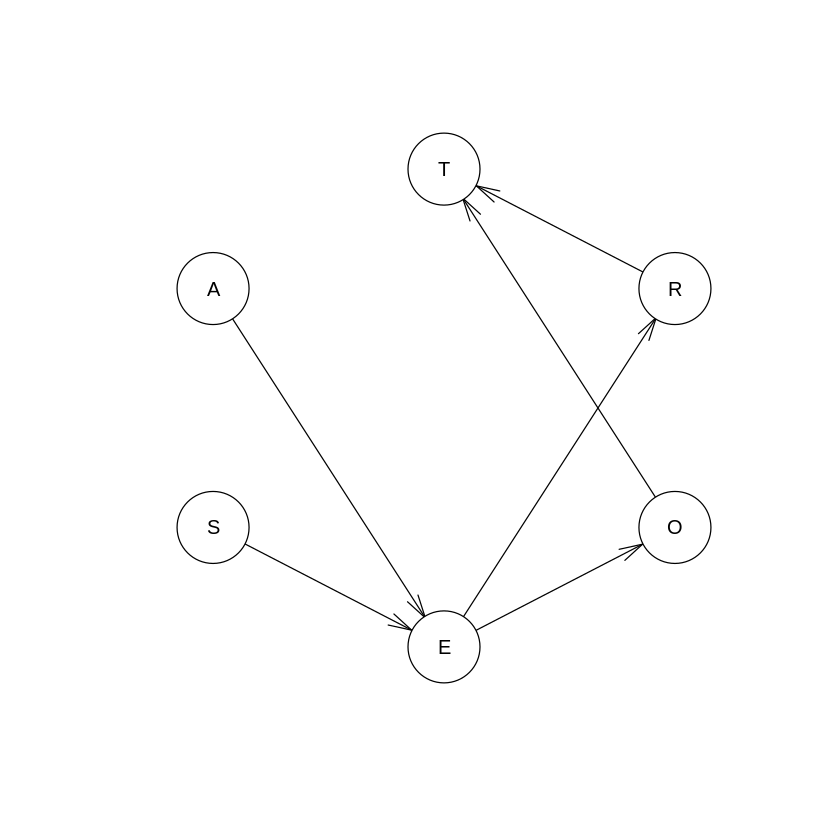

In [19]:
# clear the memory
rm(list = ls())
library(bnlearn)

# set the directory
setwd("/content/")

# create an empty graph
dag <- empty.graph(nodes = c("A", "S", "E", "O", "R", "T"))

# Add in the edges
dag <- set.arc(dag, from = "A", to = "E") # age influences education
dag <- set.arc(dag, from = "S", to = "E") # sex influences education
dag <- set.arc(dag, from = "E", to = "O") # ....
dag <- set.arc(dag, from = "E", to = "R") # ....
dag <- set.arc(dag, from = "O", to = "T") # ....
dag <- set.arc(dag, from = "R", to = "T") # ....

plot(dag)

In [20]:
# Read in the data
survey <- read.table("survey.txt", header = TRUE, colClasses = "factor") # Without this argument colClasses R would guess the class of each column (numeric, character, factor, …) from its contents; forcing factors is useful when you know the variables are discrete (e.g. for Bayesian-network packages like bnlearn, which expect categorical nodes).
head(survey)
dim(survey)

,A,R,E,O,S,T
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,adult,big,high,emp,F,car
2,adult,small,uni,emp,M,car
3,adult,big,uni,emp,F,train
4,adult,big,high,emp,M,car
5,adult,big,high,emp,M,car
6,adult,small,high,emp,F,train


[1] 500   6

### Fit the DAG (MLE)

In [6]:
?bn.fit # helper '?' to learn about bn.fit

In [21]:
# Use of the Data only
bn.mle <- bn.fit(dag, data = survey, method = "mle")

In [22]:
table(survey$S)/500


    F     M 
0.402 0.598 

In [23]:
bn.mle


  Bayesian network parameters

  Parameters of node A (multinomial distribution)

Conditional probability table:
 adult   old young 
0.472 0.208 0.320 

  Parameters of node S (multinomial distribution)

Conditional probability table:
     F     M 
0.402 0.598 

  Parameters of node E (multinomial distribution)

Conditional probability table:
 
, , S = F

      A
E          adult       old     young
  high 0.6391753 0.8461538 0.5384615
  uni  0.3608247 0.1538462 0.4615385

, , S = M

      A
E          adult       old     young
  high 0.7194245 0.8923077 0.8105263
  uni  0.2805755 0.1076923 0.1894737


  Parameters of node O (multinomial distribution)

Conditional probability table:
 
      E
O            high        uni
  emp  0.98082192 0.92592593
  self 0.01917808 0.07407407

  Parameters of node R (multinomial distribution)

Conditional probability table:
 
       E
R            high       uni
  big   0.7178082 0.8666667
  small 0.2821918 0.1333333

  Parameters of node T (multino

In [24]:
bn.mle$S # look at the CPT for S


  Parameters of node S (multinomial distribution)

Conditional probability table:
     F     M 
0.402 0.598 

### bayesian fit (with a prior, sample size of prior = 10)

In [11]:
?bn.fit

In [25]:
bn.bayes <- bn.fit(dag, data = survey, method = "bayes", iss = 10)
bn.bayes$S # This will show smoothed probabilities of S (say, M/F):


  Parameters of node S (multinomial distribution)

Conditional probability table:
         F         M 
0.4039216 0.5960784 

#### Quick Note

1. What is `iss`?

`iss` stands for **imaginary sample size**. It controls **how strong the prior belief is** in the Bayesian estimation.

When you use `method = "bayes"` in `bn.fit()`, you are saying:

> “I don’t just want to count frequencies from the data (MLE); I want to *smooth* them with a prior belief, as if I had seen some imaginary data already.”

That imaginary data has size = `iss`.


2. What is the **prior**?

The prior is assumed to be a **uniform Dirichlet distribution** unless you specify otherwise. That means:

* For each conditional distribution $P(X \mid \text{Parents}(X))$, the prior assumes **all categories of $X$** are equally likely **before seeing the real data**.
* `iss = 10` means: we act as if we had **10 fake observations**, equally distributed among the categories of $X$.

So for a binary node (like `S` = M/F):

* Prior counts = (5, 5)
* If observed data counts = (80, 20)
* Posterior counts = (80 + 5, 20 + 5) = (85, 25)
* Posterior probabilities = (85/110, 25/110)

This is a **Bayesian smoothing** technique — it **avoids zero probabilities** and **reduces overfitting** when data is sparse.


3. What does `bn.fit(..., method = "bayes", iss = 10)` do exactly?

For each node:

1. Identify its **parents** from the `dag`.
2. For each combination of parent values:

   * Get the **observed counts** of the node’s levels in the data.
   * Add **uniform pseudo-counts** from a Dirichlet prior (proportional to `iss`).
3. Compute the **posterior probabilities**:

   $$
   P(X = x \mid \text{Parents}) = \frac{n_x + \alpha_x}{N + \sum \alpha}
   $$

   where:

   * $n_x$: observed count for level $x$
   * $\alpha_x$: prior count (e.g. for uniform: $\text{iss}/k$, where $k$ is the number of levels)
   * $N$: total observed count for that parent config


4. Example: Gender node (`S`)

```r
bn.bayes$S
```

This will show smoothed probabilities of `S` (say, M/F):

If the data had:

```
S = M: 300
S = F: 200
```

Then with `iss = 10` and 2 levels:

* Prior counts = (5, 5)
* Posterior counts = (305, 205)
* Posterior probs = (305 / 510, 205 / 510)

Compare that to `bn.mle$S`, which would give (300 / 500, 200 / 500) — notice the smoothing.

### bayesian fit (with a prior, sample size of prior = 250)

In [26]:
bn.bayes2 <- bn.fit(dag, data = survey, method = "bayes", iss = 250)
bn.bayes2$S


  Parameters of node S (multinomial distribution)

Conditional probability table:
         F         M 
0.4346667 0.5653333 

### compare occupation cpt for mle and bayes fits

In [27]:
bn.mle$O


  Parameters of node O (multinomial distribution)

Conditional probability table:
 
      E
O            high        uni
  emp  0.98082192 0.92592593
  self 0.01917808 0.07407407

In [28]:
bn.bayes$O


  Parameters of node O (multinomial distribution)

Conditional probability table:
 
      E
O            high        uni
  emp  0.97432432 0.91071429
  self 0.02567568 0.08928571

In [29]:
bn.bayes2$O


  Parameters of node O (multinomial distribution)

Conditional probability table:
 
      E
O           high       uni
  emp  0.8581633 0.7211538
  self 0.1418367 0.2788462

### Notes

1. “Prior” in Bayesian statistics – the big picture

| Ingredient                                 | What it encodes                                                           | Where it comes from                                                                                 |
| ------------------------------------------ | ------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------- |
| **Prior** $P(\theta)$                      | What you believe about the parameters **before** seeing the current data. | Earlier studies, expert judgment, or simply “I have no reason to prefer one category over another.” |
| **Likelihood** $P(\text{data}\mid \theta)$ | The information supplied by the **new data** you just collected.          | Your sample, survey, experiment, …                                                                  |
| **Posterior** $P(\theta\mid \text{data})$  | Updated belief **after** combining prior information with the data.       | Computed via Bayes’ rule.                                                                           |

$$
\text{Posterior} \;=\; \frac{\text{Likelihood}\;\times\;\text{Prior}}{\text{Evidence}}
$$


2. In a Bayesian network

For every conditional‐probability table (CPT) we put a **Dirichlet prior** on the probabilities of the child node given its parent configuration.

* If a node $X$ has $k$ categories, the Dirichlet has $k$ hyper-parameters $\alpha_1,\dots,\alpha_k$.
* Those $\alpha$’s can be interpreted as “pseudo-counts” or **imaginary observations** that you pretend to have seen before collecting the real data.

Example for a binary node (`high`, `uni`) with a *uniform prior* and `iss = 10`:

| Level | Prior pseudo-count ($\alpha$) | Comment                         |
| ----- | ----------------------------- | ------------------------------- |
| high  | 5                             | “I imagine having seen 5 highs” |
| uni   | 5                             | “I imagine having seen 5 unis”  |

When real data contribute counts $(n_\text{high}, n_\text{uni})$, the **posterior** Dirichlet has parameters $(n_\text{high}+5,\, n_\text{uni}+5)$.  The resulting posterior mean (what `bn.fit()` reports) is

$$
\hat P(\text{high}) \;=\; \frac{n_\text{high}+5}{n_\text{high}+n_\text{uni}+10},
\qquad
\hat P(\text{uni})  \;=\; \frac{n_\text{uni}+5}{n_\text{high}+n_\text{uni}+10}.
$$


3. Why bother with a prior?

* **Smoothing / avoiding zeros** – If a category never appears in a small data set, MLE would assign probability 0, which breaks later inference. A mild prior keeps every probability positive.
* **Regularisation** – Prevents overfitting in sparse parts of the network by nudging extreme empirical proportions toward more reasonable values.
* **Domain knowledge** – If you actually know that one category is usually twice as common as another, you can encode that asymmetry in the prior instead of assuming uniformity.


4. Recap

*The prior is simply your starting belief about the parameters before looking at the current data.*
In `bn.fit(method = "bayes", iss = 10)` you tell R:

> “Pretend I had already seen a tiny, uniformly distributed data set of size 10 for **every** parent configuration, then update those beliefs with the real survey I just loaded.”

That blending of “imaginary” and “real” counts yields the posterior probabilities you saw in `bn.bayes`.
